In [229]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from copy import copy

In [230]:
nifty50_index_symbol = '^NSEI'

start_date = '2010-01-01'
end_date = '2019-06-30'

data = yf.download(nifty50_index_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [231]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000
mean,7561.167236,7598.586197,7512.571021,7555.766634,7555.766634,136968.849634
std,2084.658066,2086.080772,2077.707855,2081.917797,2081.917797,117889.153660
min,4623.149902,4623.149902,4531.149902,4544.200195,4544.200195,0.000000
25%,5633.799805,5659.850098,5586.450195,5627.750000,5627.750000,0.000000
50%,7630.250000,7673.700195,7579.299805,7614.350098,7614.350098,148800.000000
75%,8914.500000,8957.049805,8867.599609,8914.299805,8914.299805,200900.000000
max,12052.650391,12103.049805,12005.849609,12088.549805,12088.549805,719000.000000


In [232]:
def normalisation(col):
    new_col = (col - min(col))/(max(col) - min(col)) + 0.01  # for non zero stock prices
    return new_col

In [233]:
df = data[['Close']]

In [234]:
for col in df.columns:
    df[col] = normalisation(df[col])

/var/folders/41/13h1j2zj3plb9jjbs7dzx75c0000gn/T/ipykernel_15705/514820066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = normalisation(df[col])


In [235]:
df[:600]

,Close
Date,
2010-01-04,0.101194
2010-01-05,0.107252
2010-01-06,0.107768
2010-01-07,0.105290
2010-01-08,0.102858
...,...
2012-06-05,0.052297
2012-06-06,0.070032
2012-06-07,0.076997


In [236]:
data_arr = df[:600].to_numpy()

In [237]:
data_arr = data_arr.reshape((data_arr.shape[0], ))

In [238]:
data_arr.shape

(600,)

In [239]:
# data_arr = data_arr[:600]

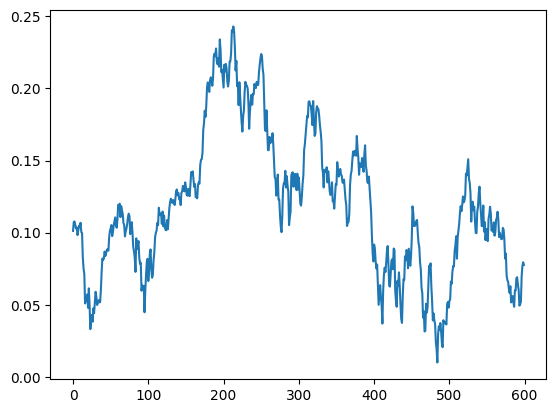

In [240]:
plt.plot(data_arr)

In [241]:
class StockMarketEnvironment:
    # action == 0-buy, 1-sell, 2-hold
    def __init__(self, starting_balance, data):
        self.data = data
        self.starting_balance = starting_balance
        self.balance = starting_balance
        self.stocks = 0
        self.portfolio = self.balance
        self.time_step = 0
        self.end = False
        self.state = np.array([self.balance, self.stocks, self.data[self.time_step]])
    
    def reset(self):
        self.balance = self.starting_balance
        self.stocks = 0
        self.portfolio = self.balance
        self.time_step = 0
        self.end = False
        self.state = np.array([self.balance, self.stocks, self.data[self.time_step]])

    def step(self, action):
        curr_state = self.state
        if action == 0:
            num_poss_buy = int(self.balance / curr_state[2])
            self.stocks += num_poss_buy
            self.balance -= num_poss_buy * curr_state[2]
        if action == 1:
            num_poss_sell = self.stocks
            self.stocks -= num_poss_sell
            self.balance += num_poss_sell * curr_state[2]
            
        next_time_state = self.time_step + 1
        if next_time_state >= self.data.shape[0] - 1:
            self.end = True
        next_state = np.array([self.balance, self.stocks, self.data[next_time_state]])

        self.portfolio = self.balance + self.stocks * curr_state[2]
        next_portfolio = self.balance + self.stocks * next_state[2]

        reward = next_portfolio - self.portfolio

        self.state = next_state
        self.portfolio = next_portfolio
        self.time_step += 1

        return (self.state, reward, self.end)
    
    def is_end(self):
        return self.end

In [242]:
def get_q_model(layers_shapes):
    input = tf.keras.Input(shape = (layers_shapes[0],))
    x = input
    for shape in layers_shapes[1:-1]:
        x = tf.keras.layers.Dense(shape, activation = 'relu')(x)
    output = tf.keras.layers.Dense(layers_shapes[-1])(x)
    model = tf.keras.Model(input, output)
    return model

critic_model = get_q_model([3, 32, 64, 3])
critic_model_final = copy(critic_model)

critic_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse')

critic_model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse')

In [243]:
action_space = [0, 1, 2]
epsilon = 1
epsilon_decay = 0.95
buffer_size = 400
buffer = []
max_iters = 100
gamma = 0.9

In [244]:
data_arr.shape[0]

600

In [245]:
balance = np.mean(data_arr)
env = StockMarketEnvironment(balance, data_arr)

In [246]:
np.array(env.state).shape

(3,)

In [247]:
curr_q = critic_model_final.predict(env.state.reshape((-1, 3)), verbose = 0)

In [248]:
curr_q[0]

array([-0.02532779, -0.00871891, -0.03208645], dtype=float32)

In [249]:
# critic_model_final.load_weights("best_trained.weights.h5")
# critic_model.load_weights("best_trained.weights.h5")

In [256]:
critic_loss_history = []
rewards_history = []
for i in range(max_iters + 400):
    action_count = [0, 0, 0]
    env.reset()
    rewards_sum = 0
    while not env.is_end():
        curr_state = env.state
        random_num = np.random.rand()
        if random_num < epsilon:
            action = np.random.choice(action_space)
        else:
            action = np.argmax(critic_model_final.predict(env.state.reshape((-1, 3)), verbose = 0))
        action_count[action] += 1
        next_state, reward, end = env.step(action)
        rewards_sum += reward

        quadruple = (curr_state, action, reward, next_state, end)
        buffer.append(quadruple)
        if len(buffer) > buffer_size:
            buffer.pop(0)

    rewards_history.append(rewards_sum)
    
    sample_indices = np.random.choice(len(buffer), size=min(50, len(buffer)), replace=False)
    train_sample = [buffer[idx] for idx in sample_indices]
    epsilon = max(epsilon * epsilon_decay, 0.1)

    critic_loss = 0
    for quadrup in train_sample:
        curr_state, action, reward, next_state, end = quadrup
        curr_q = critic_model_final.predict(curr_state.reshape((-1, 3)), verbose = 0)
        next_state_q_vals = critic_model_final.predict(next_state.reshape((-1, 3)), verbose = 0)
        target_q_val = reward + gamma * np.max(next_state_q_vals)
        target_q = copy(curr_q)
        target_q[0][action] = target_q_val

        history = critic_model.fit(curr_state.reshape((-1, 3)), target_q, verbose = 0)
        critic_loss += history.history['loss'][0]
    
    critic_loss /= len(train_sample)
    critic_loss_history.append(critic_loss)

    if i % 10 == 0:
        critic_model_final.set_weights(critic_model.get_weights())
        critic_model_final.save_weights("trained.weights.h5")
    print(i, "-> LOSS:", critic_loss, "-> REWARD:", rewards_sum, "-> Action count:", action_count)


0 -> LOSS: 0.0001675235183552104 -> REWARD: 0.11069840399491826 -> Action count: [426, 156, 17]
1 -> LOSS: 1.4317226393529835e-05 -> REWARD: -0.09601291270603757 -> Action count: [466, 122, 11]
2 -> LOSS: 0.00011797845349235558 -> REWARD: 0.47044417295953317 -> Action count: [362, 214, 23]
3 -> LOSS: 0.00021081209785052125 -> REWARD: 0.06569712639348507 -> Action count: [299, 283, 17]
4 -> LOSS: 6.652965061221039e-05 -> REWARD: 0.4188359355239735 -> Action count: [289, 286, 24]
5 -> LOSS: 0.002028938264236331 -> REWARD: 0.07200099567479482 -> Action count: [347, 222, 30]
6 -> LOSS: 0.0015660857997863787 -> REWARD: 0.27192523274480795 -> Action count: [349, 230, 20]
7 -> LOSS: 0.00016152485621660163 -> REWARD: 0.0726618664061239 -> Action count: [405, 170, 24]
8 -> LOSS: 0.00015187911635166528 -> REWARD: 0.24324735218073756 -> Action count: [292, 293, 14]
9 -> LOSS: 0.0005716102301312276 -> REWARD: 0.46481677227912943 -> Action count: [178, 241, 180]
10 -> LOSS: 0.0007068915707350243 ->

KeyboardInterrupt: 

In [257]:
critic_model_final.save_weights("best_trained.weights.h5")

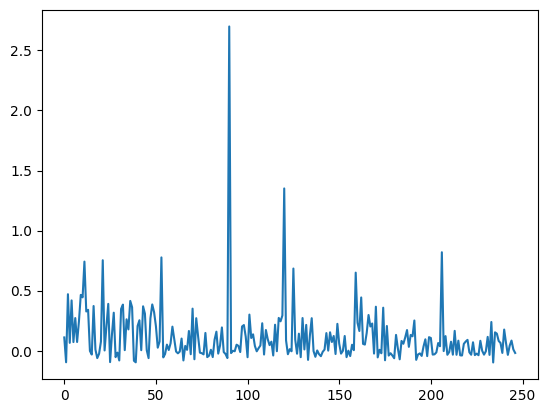

In [258]:
plt.plot(rewards_history)

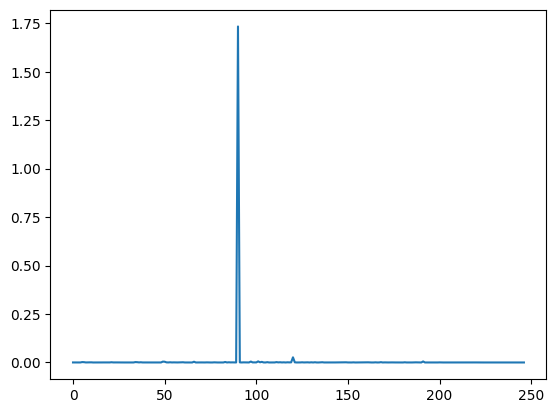

In [259]:
plt.plot(critic_loss_history)

In [260]:
action_count = [0, 0, 0]
env.reset()
rewards_sum = 0
stock_history = []
while not env.is_end():
    curr_state = env.state
    action = np.argmax(critic_model_final.predict(env.state.reshape((-1, 3)), verbose = 0))
    action_count[action] += 1
    stock_history.append(env.stocks)
    next_state, reward, end = env.step(action)
    rewards_sum += reward
print(rewards_sum)
print(stock_history)

-0.02360708435819754
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [261]:
print(env.starting_balance)
print(env.portfolio)

0.1177831996015575
0.09417611524335999
